<center><img src="header.png" alt="spotify header"></center>
<h1 align="center">Predicting Song Popularity with the Spotify API</h1>
<h3 align="center">Mara Hubelbank — DS4400 Course Project</h3> 

<hr style="border: 3px solid #1ed760">

# Requirements

In [53]:
# !pip install --upgrade scikit-learn
# !pip install imblearn
# !pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

from matplotlib.colors import ListedColormap

<hr style="border: 3px solid #1ed760">

# Data Collection

In [237]:
spotify = pd.read_csv('https://raw.githubusercontent.com/DorAzaria/Spotify-Machine-Learning-Project/main/data.csv')

# Move important columns to the front, and sort the rest
for col_name in ['artists', 'name', 'id']:
    col = spotify.pop(col_name)
    spotify.insert(0, col_name, col)

# Drop release_date, since we only care about release_year
spotify = spotify.drop('release_date', axis=1)

# Convert duration_ms to duration_mins for readability
spotify["duration_ms"] = spotify["duration_ms"]/60000
spotify = spotify.rename(columns={'duration_ms': 'duration_mins'})

# Get numeric cols for analysis and modeling
numeric_cols = spotify.select_dtypes(include=np.number).columns.tolist()
numeric_df = pd.DataFrame(data=spotify, columns=numeric_cols, index=spotify.index)

print(f"Our dataset has {len(spotify)} rows and {len(spotify.columns)} columns.")
spotify.head(3)

Our dataset has 169909 rows and 18 columns.


,id,name,artists,acousticness,danceability,duration_mins,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],0.995,0.708,2.644133,0.1950,0,0.563,10,0.1510,-12.428,1,0,0.0506,118.469,0.7790,1928
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",0.994,0.379,4.702217,0.0135,0,0.901,8,0.0763,-28.454,1,0,0.0462,83.972,0.0767,1928
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],0.604,0.749,1.738333,0.2200,0,0.000,5,0.1190,-19.924,0,0,0.9290,107.177,0.8800,1928


In [55]:
print("Count null values:\n")
print(spotify.isnull().sum())

Count null values:

id                  0
name                0
artists             0
acousticness        0
danceability        0
duration_mins       0
energy              0
explicit            0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
popularity          0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64


In [56]:
print("Count unique values:\n")
print(spotify.nunique())
print(f"\n{len(spotify) - len(spotify['id'].unique())} songs are duplicates (by ID).")

Count unique values:

id                  169909
name                132940
artists              33375
acousticness          4714
danceability          1232
duration_mins        50212
energy                2332
explicit                 2
instrumentalness      5401
key                     12
liveness              1741
loudness             25313
mode                     2
popularity             100
speechiness           1628
tempo                84548
valence               1739
year                   100
dtype: int64

0 songs are duplicates (by ID).


<hr style="border: 3px solid #1ed760">

# Exploratory Data Analysis

The audio features collected from Spotify cover a wide range of metrics. They measure objective numeric and lyrical properties of the song, as well as subjective properties like how danceable a song is. Below we describe each feature in context and visualize distributions.

## Dataset Overview

**Source: [Spotify Web API](https://developer.spotify.com/documentation/web-api/reference/get-audio-features)**

**<span style='background:#e0e0e0'>Acousticness</span>:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

**<span style='background:#c1f7d7'>Danceability</span>:** Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

**<span style='background:#e0e0e0'>Duration_ms</span>:** The duration of the track in milliseconds.

**<span style='background:#c1f7d7'>Energy</span>:** A measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

**<span style='background:#e0e0e0'>Explicit</span>:** Binary indicator of whether the song lyrics contain swear words.

**<span style='background:#c1f7d7'>Instrumentalness</span>:** Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Values above 0.5 are intended to represent instrumental tracks. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.

**<span style='background:#e0e0e0'>Key</span>:** The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

**<span style='background:#c1f7d7'>Liveness</span>:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

**<span style='background:#e0e0e0'>Loudness</span>:** The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

**<span style='background:#c1f7d7'>Mode</span>:** Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

**<span style='background:#e0e0e0'>Popularity</span>:** The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.

**<span style='background:#c1f7d7'>Speechiness</span>:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

**<span style='background:#e0e0e0'>Tempo</span>:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

**<span style='background:#c1f7d7'>Valence</span>:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).



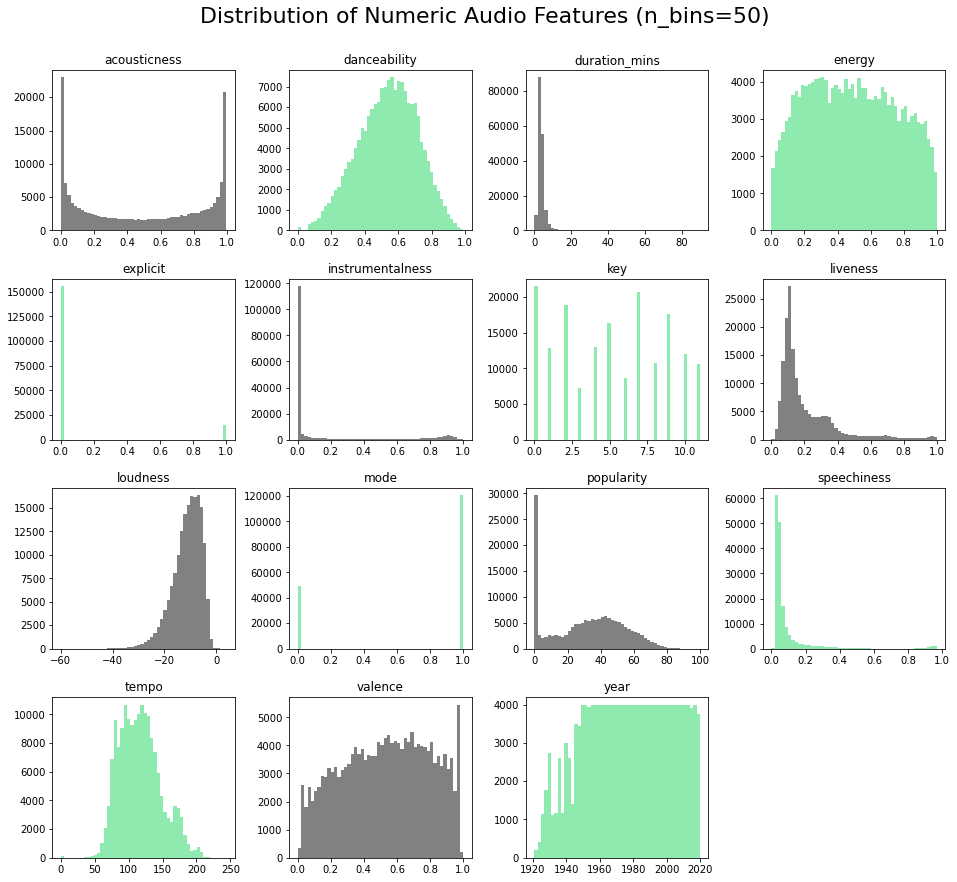

In [57]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 14.5))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
axes = axes.flatten()

for i, col_name in enumerate(numeric_cols):
    row, col = i // 4, i % 4
    color = '#050505' if row%2==0 and col%2==0 or row%2==1 and col%2==1 else '#1ed760'
    ax = axes[i]
    ax.hist(spotify[col_name], alpha=0.5, bins=50, color=color)
    ax.set_title(col_name)

axes[15].set_visible(False)

fig.suptitle("Distribution of Numeric Audio Features (n_bins=50)", y=0.94, fontsize=22)

plt.show()

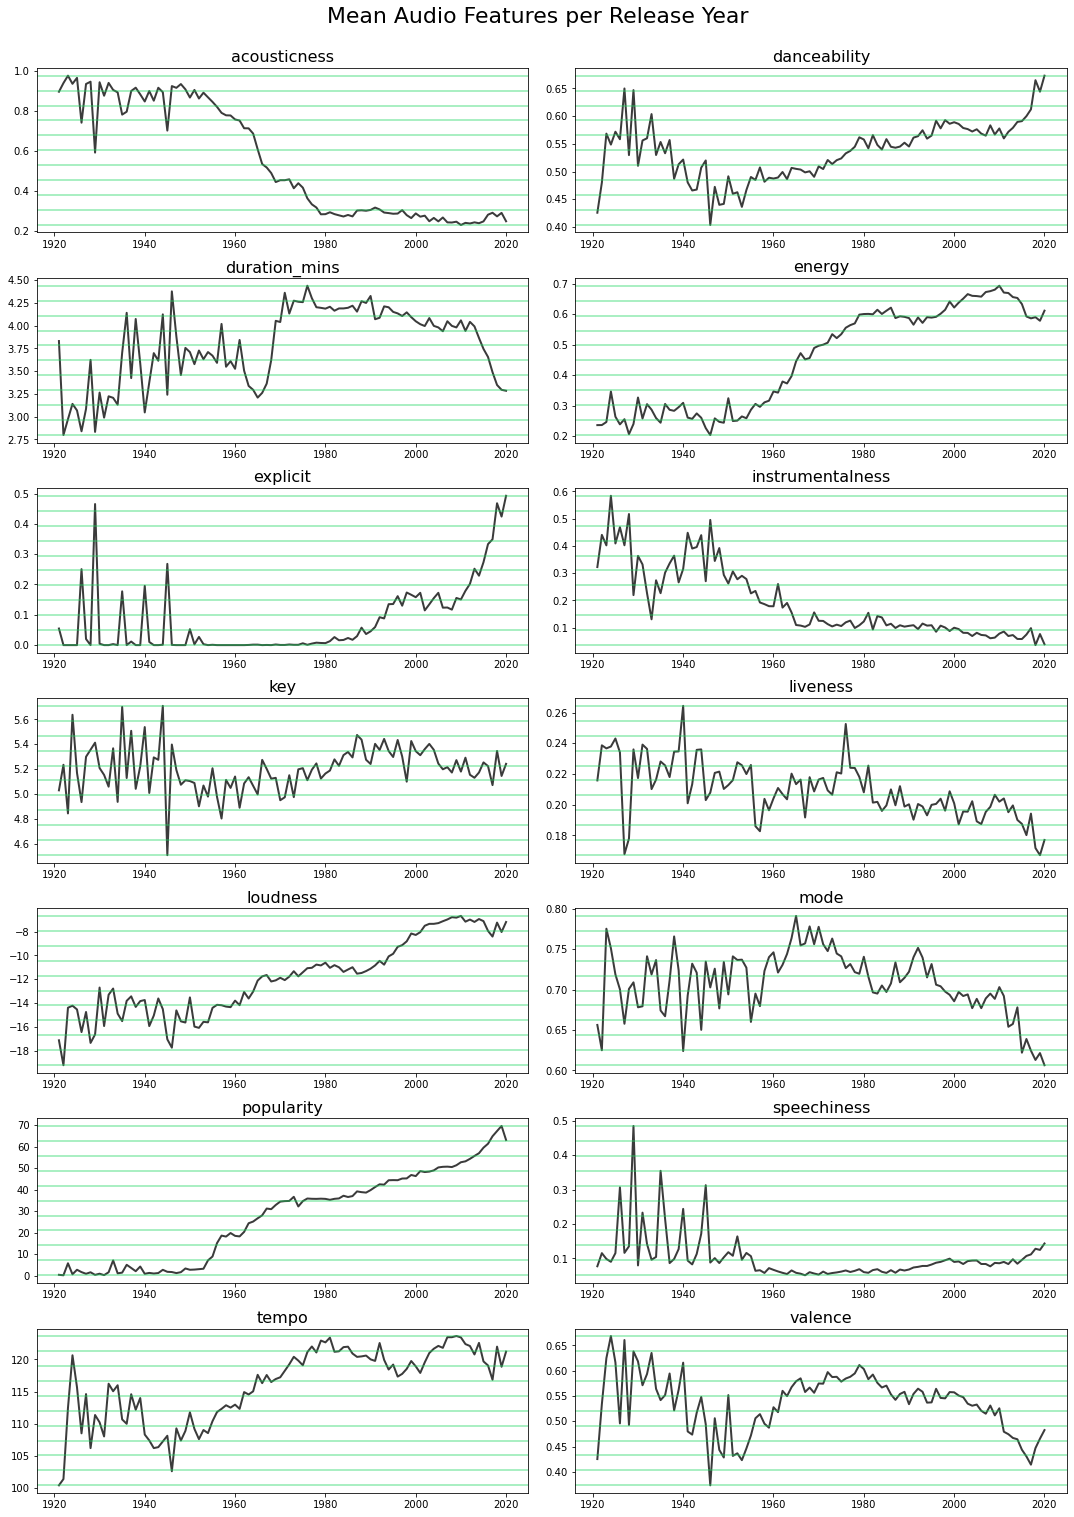

In [58]:
fig, axes = plt.subplots(7, 2, figsize=(15, 21))
fig.subplots_adjust(wspace=0.3, hspace=0.6)
axes = axes.flatten()

time_cols = [c for c in numeric_cols if c != 'year']
for i, col in enumerate(time_cols):
    data = spotify.groupby('year')[col].mean()
    data.plot(kind='line', ax=axes[i], color='#3b3b3b', lw=2)
    axes[i].set_xlabel(None)
    axes[i].set_title(col, fontsize=16)
    for j in range(11):
        axes[i].axhline(y=data.min() + j*(data.max()-data.min())/10, color='#1ed760', alpha=0.5)

fig.suptitle("Mean Audio Features per Release Year", y=1.001, fontsize=22)

plt.tight_layout()
plt.show()

## Target Selection

Looking at the dataset features, we can begin to speculate on what types of inference we can use this data for.
We think that predicting the artist and popularity of a song might be interesting. However, there are too many unique artists in the dataset, so we rule that target out.

Thus, we choose **Popularity** to be our target variable.

In [59]:
features = numeric_df.drop(['popularity'], axis=1)
features.head(1)

,acousticness,danceability,duration_mins,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,year
0,0.995,0.708,2.644133,0.195,0,0.563,10,0.151,-12.428,1,0.0506,118.469,0.779,1928


In [60]:
spotify['popularity'].describe()

count    169909.000000
mean         31.556610
std          21.582614
min           0.000000
25%          12.000000
50%          33.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64

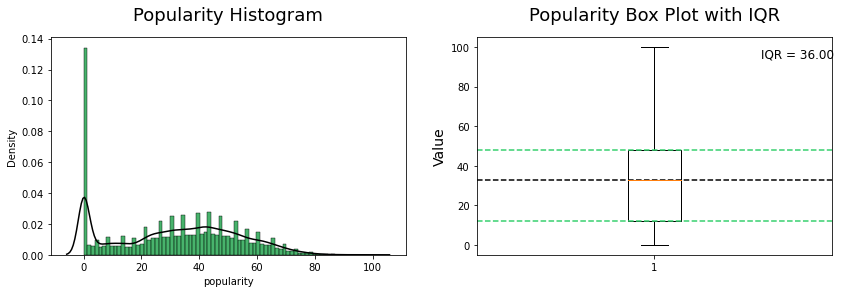

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Scatterplot
# sns.histplot(spotify['popularity'].sort_values(), color = '#0b9a3b', ax = axes[0], kde = True, kde_kws={'linecolor': 'black'})

sns.histplot(spotify['popularity'].sort_values(), color = '#0b9a3b', ax = axes[0], kde=False, stat='density')
sns.kdeplot(spotify['popularity'].sort_values(), color='black', ax=axes[0])

# axes[0].hist(spotify['popularity'].sort_values(), bins=101, color='#0b9a3b')
axes[0].set_title("Popularity Histogram", fontsize=18, y=1.05)

# IQR Boxplot
q1 = spotify['popularity'].quantile(0.25)
q3 = spotify['popularity'].quantile(0.75)
iqr = q3 - q1

axes[1].boxplot(spotify['popularity'], 0, '')
axes[1].set_ylabel('Value', fontsize=14)
axes[1].set_title('Popularity Box Plot with IQR', fontsize=18, y=1.05)

axes[1].axhline(y=q1, color='#35d06d', linestyle='--')
axes[1].axhline(y=q3, color='#35d06d', linestyle='--')
axes[1].axhline(y=spotify['popularity'].median(), color='black', linestyle='--')
axes[1].text(0.8, 0.95, f'IQR = {iqr:.2f}', transform=plt.gca().transAxes, fontsize=12, va='top')

plt.show()

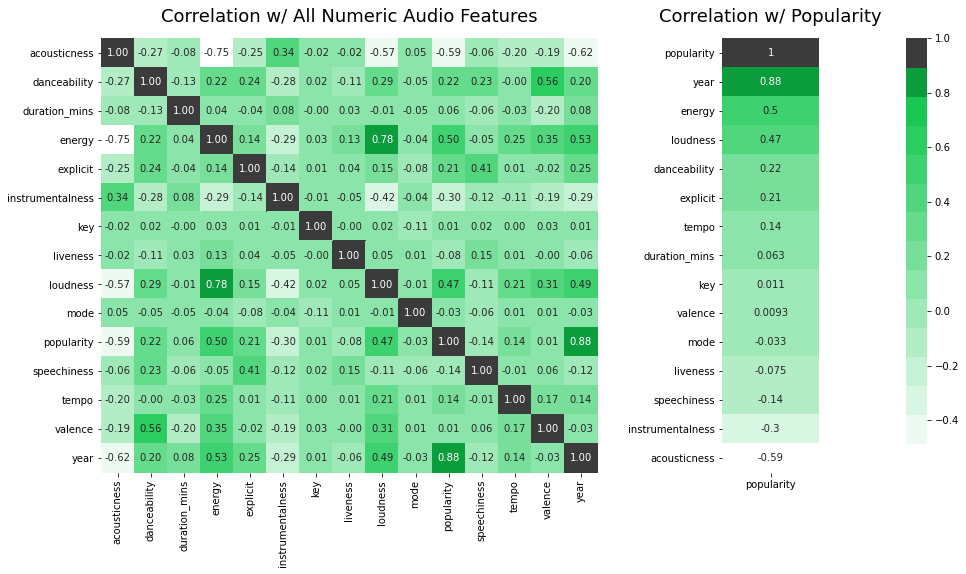

In [62]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), gridspec_kw={'width_ratios': [2.3, 1]})
fig.subplots_adjust(wspace=0.35)


def lighten_color(hex_code, percent):
    hex_code = hex_code.lstrip('#')
    r, g, b = tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4))
    r += min(255, round((255 - r) * percent / 100))
    g += min(255, round((255 - g) * percent / 100))
    b += min(255, round((255 - b) * percent / 100))
    return '#' + '{:02x}{:02x}{:02x}'.format(r, g, b)

# Heatmap w/ All
corr_matrix = spotify.iloc[:, 3:].corr()
cmap = ListedColormap([lighten_color('#0ec64b', 100-x) for x in range(0, 101, int(100/12))] + ['#0b9d3c', '#3b3b3b'])
sns.heatmap(corr_matrix, annot=True, cmap=cmap, ax=axs[0], fmt='.2f', cbar=False)
axs[0].set_title("Correlation w/ All Numeric Audio Features", y=1.025, fontsize=18)

# Heatmap w/ Popularity
corr = numeric_df.corr()[['popularity']].sort_values(by='popularity', ascending=False)

heatmap = sns.heatmap(corr, annot=True, cmap=cmap, ax=axs[1], cbar_kws={'pad':0.4}) #annot_kws={"fontsize":14}
axs[1].set_title('Correlation w/ Popularity', fontdict={'fontsize':18}, pad=16);

plt.show()

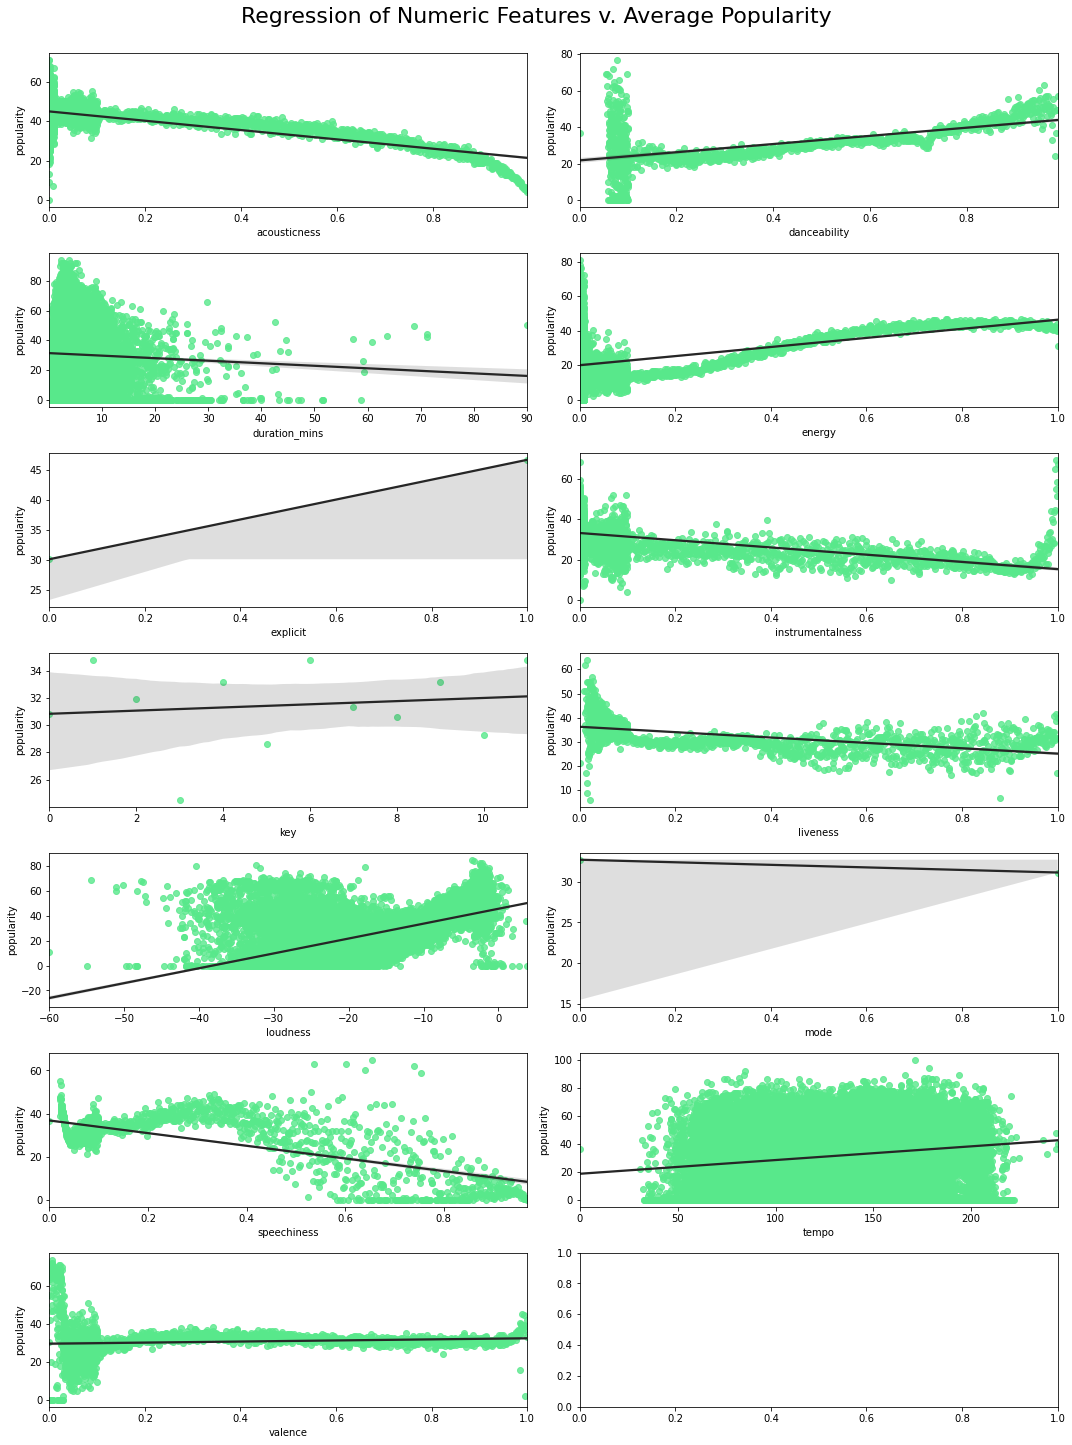

In [159]:
fig, axes = plt.subplots(7, 2, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(list(features.columns)):
    data = spotify.groupby(col)['popularity'].mean().to_frame().reset_index()
    sns.regplot(x=col, y='popularity', data=data, ax=axes[i], scatter_kws={"color": "#58e88b"}, line_kws={"color": "#262626"})
    axes[i].set_xlabel(col)

fig.suptitle("Regression of Numeric Features v. Average Popularity", y=1.001, fontsize=22)

plt.tight_layout()
plt.show()

## Feature Selection

From our exploratory data analysis, we can see that the strongest correlation is between popularity and year, which makes sense, since according to the feature definitions, recency factors into a song's calculated popularity score. Further investigation of this relationship is demonstrated below.

**Therefore, due to the very high linear correlation between year and our target variable, year will be excluded from our feature set.**

In [64]:
features = features.drop('year', axis=1)
features.columns

Index(['acousticness', 'danceability', 'duration_mins', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence'],
      dtype='object')

<hr style="border: 3px solid #1ed760">

# Binary Classification

In our first attempt, we tried to model this as a regression problem, with popularity as a continuous variable 0-100. Performance was very poor, so we looked around at existing solutions, and found that most people make this into a binary classification problem (popular / unpopular). 

## Data Preparation
### Target Variable Binarization
After investigating the split of popular/unpopular songs, we set a threshold of 50%. In other words, if a song has 50% popularity or higher, it is deemed "popular".

In [169]:
popularity_binary = spotify_binary['popularity'].apply(lambda x: 1 if x > 50 else 0)
pop_value_counts = popularity_binary.value_counts()

print(pop_value_counts)
print()
print("Percentages:")
print(round(popularity_binary.value_counts(normalize=True) * 100))

0    134051
1     35858
Name: popularity, dtype: int64

Percentages:
0    79.0
1    21.0
Name: popularity, dtype: float64


### Cost-Sensitivity
Considering the above split of data, we experiment with cost-sensitive learning by assigning class weights.

In [175]:
total = pop_value_counts.sum()
class_weights = {k: (total - v) / v for k, v in pop_value_counts.items()}

print(class_weights)

{0: 0.2674952070480638, 1: 3.7383847398070165}


### One-Hot Encoding

In [140]:
features_eng = spotify[features.columns].copy()
features_eng.head(1)

,acousticness,danceability,duration_mins,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,0.995,0.708,2.644133,0.195,0,0.563,10,0.151,-12.428,1,0.0506,118.469,0.779


In [141]:
# One categorical, two binary variables
features_eng['key'] = features_eng['key'].astype('category')
features_eng['mode'] = features_eng['mode'].astype('category')
features_eng['explicit'] = features_eng['explicit'].astype('category')

features_eng = pd.get_dummies(features_eng, columns=['key'])
features_eng = pd.get_dummies(features_eng, columns=['mode'])
features_eng = pd.get_dummies(features_eng, columns=['explicit'])

for new_col in features_eng.columns[10:]:
    features_eng[new_col] = features_eng[new_col].astype(int)
    
features_eng.head(1)

,acousticness,danceability,duration_mins,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1,explicit_0,explicit_1
0,0.995,0.708,2.644133,0.195,0.563,0.151,-12.428,0.0506,118.469,0.779,...,0,0,0,0,1,0,0,1,1,0


In [151]:
# scaler = MinMaxScaler()
scaler = RobustScaler()
transformed = scaler.fit_transform(features_eng)

features_scaled = pd.DataFrame(transformed, columns = features_eng.columns)
features_scaled.head(1)

,acousticness,danceability,duration_mins,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1,explicit_0,explicit_1
0,0.6339,0.64,-0.543429,-0.639821,6.483825,0.097205,-0.265778,0.138272,0.087473,0.550351,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Class Imbalance
Lastly, we try running our models with the exact same number of samples, to test the extent of the effect of the class imbalance on performance.

In [208]:
num_minority = pop_value_counts[1]
print(num_minority)

minority_rows = popularity_binary[popularity_binary == 1].index
sampled_majority_rows = popularity_binary[popularity_binary == 0].sample(num_minority, replace=True, random_state=42).index

# select the corresponding subset of features in X
features_balanced = features.loc[sampled_majority_rows, :].append(features.loc[minority_rows, :])
popularity_binary_balanced = popularity_binary.loc[sampled_majority_rows].append(popularity_binary.loc[minority_rows])

popularity_binary_balanced.value_counts()

35858


0    35858
1    35858
Name: popularity, dtype: int64

## Modeling

### Train-Test Split

In [230]:
# Set to popularity_binary or popularity_binary_balanced
y = popularity_binary_balanced

# Set to features, features_eng, features_scaled, or features_balanced
X = features_balanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [231]:
def run_model(model, alg_name, multi=False):    
    model.fit(X_train, y_train)
    
    def get_report(test):
        X_set = X_test if test else X_train
        y_actual = y_test if test else y_train
        
        y_pred = model.predict(X_set)
    
        cm = confusion_matrix(y_actual, y_pred)
        report = classification_report(y_actual, y_pred, zero_division=0)
        
        # accuracy = accuracy_score(y_actual, y_pred)
        # results.append((alg_name, accuracy, model))
        return report
    
    train_rep = get_report(False).split('\n')[:-1]
    test_rep = get_report(True).split('\n')[:-1]
    
    print('='*113)
    m = "MULTI-" if multi else ""
    print(alg_name.upper() + f" {m}CLASSIFICATION MODEL REPORT")
    
    print('-'*113)
    len_line, train_title = len(train_rep[0]), 'Training Set Performance'
    print(train_title + ' '*(len_line-len(train_title)) + '\t|   Testing Set Performance')
    print('-'*113)
    
    for train_line, test_line in zip(train_rep, test_rep):
        if len(train_line) < 1: 
            print(' '*len_line + '\t|')
        else:
            print(train_line + '\t|   ' + test_line)
    
    print('-'*113)
    
    if hasattr(model, 'coef_'):
        coefs = np.abs(model.coef_[0])
    elif hasattr(model, 'feature_importances_'):
        coefs = np.abs(model.feature_importances_)
    else:
        print(f'The {alg_name} model does not have a coef_ or feature_importances_ attribute.')
        coefs = None
    
    if coefs is not None:
        sorted_index = np.argsort(coefs)[::-1]
        print('Feature Importances:')
        for i in sorted_index:
            print('> {}: {:.3f}'.format(list(X_train.columns)[i], coefs[i]))

    print('='*113)

### Logistic Regression Classifier

In [232]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

model = LogisticRegression()
run_model(model, "logistic regression")

# Base: acc=0.82, F1=0.65
# With eng: acc=0.82
# With eng + minmax scaler: acc=0.82
# With eng + robust scaler: acc=0.82
# With class weights: acc=0.46
# With balance: acc=0.74, F1=0.735

LOGISTIC REGRESSION CLASSIFICATION MODEL REPORT
-----------------------------------------------------------------------------------------------------------------
Training Set Performance                             	|   Testing Set Performance
-----------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support	|                 precision    recall  f1-score   support
                                                     	|
           0       0.74      0.72      0.73     28675	|              0       0.74      0.73      0.73      7183
           1       0.73      0.75      0.74     28697	|              1       0.73      0.75      0.74      7161
                                                     	|
    accuracy                           0.74     57372	|       accuracy                           0.74     14344
   macro avg       0.74      0.74      0.74     57372	|      macro avg       0.74 

### Decision Tree Classifier

In [233]:
model = DecisionTreeClassifier()
run_model(model, "decision tree")

# Base: acc=0.76, F1=65
# With eng: acc=0.76
# With eng + minmax scaler: acc=0.76
# With eng + robust scaler: acc=0.76
# With class weights: acc=0.77
# With balance: acc=0.71, F1=0.715

DECISION TREE CLASSIFICATION MODEL REPORT
-----------------------------------------------------------------------------------------------------------------
Training Set Performance                             	|   Testing Set Performance
-----------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support	|                 precision    recall  f1-score   support
                                                     	|
           0       1.00      1.00      1.00     28675	|              0       0.71      0.73      0.72      7183
           1       1.00      1.00      1.00     28697	|              1       0.72      0.69      0.71      7161
                                                     	|
    accuracy                           1.00     57372	|       accuracy                           0.71     14344
   macro avg       1.00      1.00      1.00     57372	|      macro avg       0.71      0

### K-Nearest Neighbors Classifier

In [234]:
# # undersample = RandomUnderSampler(sampling_strategy='majority')
# oversample = RandomOverSampler(sampling_strategy='minority')
# X_train_resampled, y_train_resampled = oversample.fit_resample(X_TRAIN, Y_TRAIN)

model = KNeighborsClassifier()
run_model(model, "k-nearest neighbors")

# Base: acc=0.79, F1=0.64
# With eng: acc=0.79
# With eng + minmax scaler: acc=0.80
# With eng + robust scaler: acc=0.80
# With class weights: N/A
# With balance: acc=0.69, F1=0.69

K-NEAREST NEIGHBORS CLASSIFICATION MODEL REPORT
-----------------------------------------------------------------------------------------------------------------
Training Set Performance                             	|   Testing Set Performance
-----------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support	|                 precision    recall  f1-score   support
                                                     	|
           0       0.79      0.79      0.79     28675	|              0       0.70      0.68      0.69      7183
           1       0.79      0.80      0.79     28697	|              1       0.69      0.70      0.69      7161
                                                     	|
    accuracy                           0.79     57372	|       accuracy                           0.69     14344
   macro avg       0.79      0.79      0.79     57372	|      macro avg       0.69 

### Decision Tree & AdaBoost Classifier

In [235]:
dt_b = DecisionTreeClassifier()
model = AdaBoostClassifier(estimator=dt_b)
run_model(model, "AdaBoost Classifier")

# Base: acc=0.79, F1=66.5
# With eng: acc=0.79
# With eng + minmax scaler: acc=0.79
# With eng + robust scaler: acc=0.80
# With class weights: acc=0.71, F1=0.71

ADABOOST CLASSIFIER CLASSIFICATION MODEL REPORT
-----------------------------------------------------------------------------------------------------------------
Training Set Performance                             	|   Testing Set Performance
-----------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support	|                 precision    recall  f1-score   support
                                                     	|
           0       1.00      1.00      1.00     28675	|              0       0.68      0.81      0.74      7183
           1       1.00      1.00      1.00     28697	|              1       0.76      0.62      0.68      7161
                                                     	|
    accuracy                           1.00     57372	|       accuracy                           0.71     14344
   macro avg       1.00      1.00      1.00     57372	|      macro avg       0.72 

### Random Forest Classifier

In [236]:
model = RandomForestClassifier()
run_model(model, "Random Forest")

# Base: acc=0.83, F1=0.71
# With eng: acc=0.83
# With eng + minmax scaler: acc=0.83
# With eng + robust scaler: acc=0.82
# With class weights: acc=0.79, F1=0.785

RANDOM FOREST CLASSIFICATION MODEL REPORT
-----------------------------------------------------------------------------------------------------------------
Training Set Performance                             	|   Testing Set Performance
-----------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support	|                 precision    recall  f1-score   support
                                                     	|
           0       1.00      1.00      1.00     28675	|              0       0.78      0.80      0.79      7183
           1       1.00      1.00      1.00     28697	|              1       0.79      0.77      0.78      7161
                                                     	|
    accuracy                           1.00     57372	|       accuracy                           0.79     14344
   macro avg       1.00      1.00      1.00     57372	|      macro avg       0.79      0

<hr style="border: 3px solid #1ed760">

# Multi-Classification

After completing binary classification, we wanted to experiment with multiple classes of popularity to more closely reflect the true continuous nature of Spotify's popularity scoring algorithm. This section is underdeveloped due to time and resource constraints. In particular, it was very difficult to capture the Extremely Popular class (>80% popularity), even with cost-sensitive learning. Rather than change the bins, such as combining the top echelon of Spotify songs with the Very Popular bin (60%-80%), we recommend that future extensions of this project find more samples of the underrepresented Extremely Popular class.

## Data Preparation
### Target Variable

As we can see in the exploratory data analysis section, there are many more unpopular songs than popular songs. We use relatively large bins, and then balance the bin amounts.

In [72]:
data = spotify.copy()

print("First attempt: Put the values into evenly spaced bins:\n")
n_bins = 6
binned_data = pd.cut(data['popularity'], bins=n_bins)
bin_counts = binned_data.value_counts().sort_index()
print(bin_counts)

perc_0 = round(100*spotify['popularity'].value_counts()[0]/len(spotify))
print(f'\nThe bins above are not balanced enough, because {perc_0}% of songs in the dataset have a 0% popularity score.')
print('This makes sense, because streaming platforms like Spotify make it very easy for anyone to put out music.')
print('Therefore, we create a separate bin just for songs with popularity <1%:\n')

data.loc[((data.popularity >= 0) & (data.popularity < 1)), "popularity_bin" ] = 1
data.loc[((data.popularity >= 1) & (data.popularity <= 20)), "popularity_bin" ] = 2
data.loc[((data.popularity > 20) & (data.popularity <= 40)), "popularity_bin" ] = 3
data.loc[((data.popularity > 40) & (data.popularity <= 60)), "popularity_bin" ] = 4
data.loc[((data.popularity > 60) & (data.popularity <= 80)), "popularity_bin" ] = 5
data.loc[((data.popularity > 80) & (data.popularity <= 100)), "popularity_bin" ] = 6

TARGET = data["popularity_bin"].astype("int")

print(TARGET.value_counts().sort_index())

First attempt: Put the values into evenly spaced bins:

(-0.1, 16.667]      47892
(16.667, 33.333]    37074
(33.333, 50.0]      49085
(50.0, 66.667]      28561
(66.667, 83.333]     7085
(83.333, 100.0]       212
Name: popularity, dtype: int64

The bins above are not balanced enough, because 16% of songs in the dataset have a 0% popularity score.
This makes sense, because streaming platforms like Spotify make it very easy for anyone to put out music.
Therefore, we create a separate bin just for songs with popularity <1%:

1    27357
2    25831
3    51836
4    49268
5    15160
6      457
Name: popularity_bin, dtype: int64


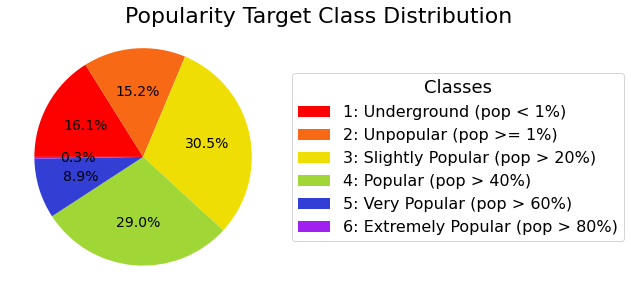

In [173]:
import pandas as pd
import matplotlib.pyplot as plt

colors = ['#FD0100', '#F76915', '#EEDE04', '#A0D636', '#333ED4', '#A020F0']

value_counts = TARGET.value_counts().sort_index()

labels = ['1: Underground (pop < 1%)', 
          '2: Unpopular (pop >= 1%)', 
          '3: Slightly Popular (pop > 20%)',
          '4: Popular (pop > 40%)', 
          '5: Very Popular (pop > 60%)', 
          '6: Extremely Popular (pop > 80%)']

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(value_counts, labels=None, autopct='%1.1f%%', colors=colors,
       textprops={'fontsize': 14}, startangle=180, counterclock=False)
plt.title(None)
legend = plt.legend(labels=labels, title='Classes', loc='center right', bbox_to_anchor=(2.3, 0.5), fontsize=16)
legend.get_title().set_fontsize(18)

plt.suptitle('Popularity Target Class Distribution', fontsize=22, x=1, y=0.92)
plt.show()

In [174]:
CLASS_WEIGHTS = {k: 100/v for k, v in value_counts.items()}
CLASS_WEIGHTS

{1: 0.00365537156851994,
 2: 0.0038713174093143897,
 3: 0.0019291612007099313,
 4: 0.0020297150280100674,
 5: 0.006596306068601583,
 6: 0.2188183807439825}

## Modeling

Note that we comment out the grid-seach cells in case the grader is to run the src, because these take a very long time.

### Train-Test Split

In [75]:
features

,acousticness,danceability,duration_mins,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,0.9950,0.708,2.644133,0.1950,0,0.563000,10,0.1510,-12.428,1,0.0506,118.469,0.7790
1,0.9940,0.379,4.702217,0.0135,0,0.901000,8,0.0763,-28.454,1,0.0462,83.972,0.0767
2,0.6040,0.749,1.738333,0.2200,0,0.000000,5,0.1190,-19.924,0,0.9290,107.177,0.8800
3,0.9950,0.781,3.012667,0.1300,0,0.887000,1,0.1110,-14.734,0,0.0926,108.003,0.7200
4,0.9900,0.210,11.462217,0.2040,0,0.908000,11,0.0980,-16.829,1,0.0424,62.149,0.0693
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169904,0.1730,0.875,2.730000,0.4430,1,0.000032,1,0.0891,-7.461,1,0.1430,100.012,0.3060
169905,0.0167,0.719,2.791133,0.3850,0,0.031300,8,0.1110,-10.907,1,0.0403,128.000,0.2700
169906,0.5380,0.514,3.011667,0.5390,0,0.002330,7,0.1080,-9.332,1,0.1050,123.700,0.1530
169907,0.0714,0.646,2.788467,0.7610,0,0.000000,1,0.2220,-2.557,1,0.0385,129.916,0.4720


In [76]:
# y_multi = TARGET
# X_train_multi, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, y_multi, test_size = 0.2, random_state = 42)

y = TARGET
X = features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Logistic Regression Classifier

We chose to use the lbfgs solver, as it's recommended when the number of samples is much larger than the number of features, and is suitable for multiclass classification problems.

In [77]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# model = LogisticRegression(multi_class='multinomial' , solver='lbfgs', max_iter=100, class_weight=None)
# run_model(model, "logistic regression")

# # Base performance: acc=0.42 

In [78]:
# param_grid = {
#     'penalty': ['none', 'l2'],
#     'C': np.logspace(-4, 4, 20),
# }

# lr = LogisticRegression(solver='lbfgs')
# scorer = make_scorer(f1_score, average='weighted')

# grid_search = GridSearchCV(
#     estimator=lr,
#     param_grid=param_grid,
#     scoring=scorer,
#     cv=5,
#     n_jobs=-1
# )

# grid_search.fit(X_TRAIN, Y_TRAIN)

# print("Best hyperparameters: ", grid_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

#### Cross-Validation Results

```
Best hyperparameters:  {'C': 0.0001, 'penalty': 'none'}
Best cross-validation score: 0.37
```

In [79]:
model = LogisticRegression(multi_class='multinomial' , solver='lbfgs', max_iter=10000, C=0.0001)
run_model(model, "logistic regression", multi=True)

LOGISTIC REGRESSION MULTI CLASSIFICATION MODEL REPORT
-----------------------------------------------------------------------------------------------------------------
Training Set Performance                             	|   Testing Set Performance
-----------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support	|                 precision    recall  f1-score   support
                                                     	|
           1       0.44      0.40      0.42     21827	|              1       0.45      0.41      0.43      5530
           2       0.29      0.00      0.00     20701	|              2       0.31      0.00      0.00      5130
           3       0.39      0.55      0.46     41539	|              3       0.39      0.55      0.46     10297
           4       0.44      0.66      0.53     39364	|              4       0.45      0.66      0.54      9904
           5       0

### Decision Tree Classifier


In [80]:
# model = DecisionTreeClassifier(class_weight=None)
# run_model(model, "decision tree")
# # Base performance: acc=0.45 

In [81]:
# dtc = DecisionTreeClassifier()

# params = {'max_depth': [5, 10, 15, 20],
#           'min_samples_split': [2, 5, 10],
#           'min_samples_leaf': [1, 2, 4],
#           'criterion': ['gini', 'entropy']}

# grid_search = GridSearchCV(dtc, param_grid=params, cv=5, n_jobs=-1)
# grid_search.fit(X_TRAIN, Y_TRAIN)

# print("Best parameters: ", grid_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

#### Cross-Validation Results
```
Best parameters:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best cross-validation score: 0.52

```

In [92]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4, min_samples_split=10)
run_model(model, "decision tree")

DECISION TREE  CLASSIFICATION MODEL REPORT
-----------------------------------------------------------------------------------------------------------------
Training Set Performance                             	|   Testing Set Performance
-----------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support	|                 precision    recall  f1-score   support
                                                     	|
           1       0.69      0.77      0.73     21827	|              1       0.67      0.74      0.70      5530
           2       0.44      0.41      0.42     20701	|              2       0.40      0.37      0.39      5130
           3       0.52      0.59      0.55     41539	|              3       0.50      0.57      0.54     10297
           4       0.54      0.57      0.56     39364	|              4       0.53      0.55      0.54      9904
           5       0.59      0.

### K-Nearest Neighbors Classifier


kNN doesn't have a class weights hyperparameter, so instead we use oversampling. However, our performance still isn't great. This is expected, because kNN tends to not perform well on imbalanced datasets, as it becomes biased towards the majority instances of the training space.

In [82]:
# # undersample = RandomUnderSampler(sampling_strategy='majority')
# oversample = RandomOverSampler(sampling_strategy='minority')
# X_train_resampled, y_train_resampled = oversample.fit_resample(X_TRAIN, Y_TRAIN)

# model = KNeighborsClassifier()
# run_model(model, "k-nearest neighbors", X_train_resampled, y_train_resampled)
# # Base performance: acc=0.41

In [83]:
# knn = KNeighborsClassifier()

# param_grid = {
#     'n_neighbors': [3, 5, 7],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan']
# }

# grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5, scoring='f1_macro')
# grid_search.fit(X_TRAIN, Y_TRAIN)

# print("Best hyperparameters:", grid_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

#### Cross-Validation Results
```
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best cross-validation score: 0.34
```

In [93]:
# # undersample = RandomUnderSampler(sampling_strategy='majority')
# oversample = RandomOverSampler(sampling_strategy='minority')
# X_train_resampled, y_train_resampled = oversample.fit_resample(X_TRAIN, Y_TRAIN)

model = KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')
run_model(model, "k-nearest neighbors")

K-NEAREST NEIGHBORS  CLASSIFICATION MODEL REPORT
-----------------------------------------------------------------------------------------------------------------
Training Set Performance                             	|   Testing Set Performance
-----------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support	|                 precision    recall  f1-score   support
                                                     	|
           1       0.99      1.00      1.00     21827	|              1       0.55      0.52      0.54      5530
           2       0.99      0.99      0.99     20701	|              2       0.33      0.30      0.32      5130
           3       0.99      1.00      0.99     41539	|              3       0.44      0.48      0.45     10297
           4       0.99      0.99      0.99     39364	|              4       0.46      0.51      0.48      9904
           5       1.00  

### Decision Tree & AdaBoost Classifier

In [84]:
# dt_b = DecisionTreeClassifier(max_depth=1, random_state=42, c)
# model = AdaBoostClassifier(estimator=dt_b)
# run_model(model, "AdaBoost Classifier")
# # Base performance: acc=0.51

In [85]:
# dt = DecisionTreeClassifier()
# abc = AdaBoostClassifier(base_estimator=dt)

# param_grid = {
#     'base_estimator__criterion': ['gini', 'entropy'],
#     'base_estimator__splitter': ['best', 'random'],
#     'n_estimators': [50, 100, 150, 200],
#     'learning_rate': [0.01, 0.1, 1.0, 10.0]
# }

# grid_search = GridSearchCV(estimator=abc, param_grid=param_grid, scoring='f1_macro', cv=5, n_jobs=-1)
# grid_search.fit(X_TRAIN, Y_TRAIN)

# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

#### Cross-Validation Results
```
Best parameters: {'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'random', 'learning_rate': 10.0, 'n_estimators': 200}
Best cross-validation score: 0.44
```

In [94]:
# dt_b = DecisionTreeClassifier(max_depth=1, random_state=42, class_weight=None, criterion='gini', splitter='random')
# model = AdaBoostClassifier(estimator=dt_b, learning_rate=10.0, n_estimators=200)

dt_b = DecisionTreeClassifier(random_state=42, class_weight=None)
model = AdaBoostClassifier(estimator=dt_b)
run_model(model, "AdaBoost Classifier")

ADABOOST CLASSIFIER  CLASSIFICATION MODEL REPORT
-----------------------------------------------------------------------------------------------------------------
Training Set Performance                             	|   Testing Set Performance
-----------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support	|                 precision    recall  f1-score   support
                                                     	|
           1       0.99      1.00      1.00     21827	|              1       0.68      0.69      0.69      5530
           2       1.00      0.99      0.99     20701	|              2       0.39      0.36      0.38      5130
           3       0.99      1.00      0.99     41539	|              3       0.48      0.51      0.49     10297
           4       0.99      0.99      0.99     39364	|              4       0.48      0.49      0.48      9904
           5       1.00  

### Random Forest Classifier


In [86]:
# model = RandomForestClassifier(n_estimators=10, class_weight=None)
# run_model(model, "Random Forest")
# # Base performance: acc=0.52

In [87]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'class_weight': [None, 'balanced']
# }

# rf = RandomForestClassifier(random_state=42)

# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
# grid_search.fit(X_TRAIN, Y_TRAIN)

# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

#### Cross-Validation Results
```
Best parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score: 0.46
```

In [95]:
model = RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=200)
run_model(model, "Random Forest")

RANDOM FOREST  CLASSIFICATION MODEL REPORT
-----------------------------------------------------------------------------------------------------------------
Training Set Performance                             	|   Testing Set Performance
-----------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support	|                 precision    recall  f1-score   support
                                                     	|
           1       0.91      0.93      0.92     21827	|              1       0.70      0.78      0.74      5530
           2       0.91      0.84      0.87     20701	|              2       0.46      0.39      0.43      5130
           3       0.82      0.92      0.87     41539	|              3       0.53      0.64      0.58     10297
           4       0.82      0.87      0.84     39364	|              4       0.56      0.56      0.56      9904
           5       0.95      0.

#### The below models couldn't be run due to compute constraints, but should be evaluated in future extensions of the work.

### XGBoost Classifier

In [89]:
# xgboost needs labels starting at 0, so we shift the labels down 1
# model = xgb.XGBClassifier(objective="multi:softmax", num_class=6, max_depth=3)
# run_model(model, 'XGBoost', y_traiacn=Y_TRAIN - 1, y_test=Y_TEST - 1)

# # Base performance: acc=0.56

In [90]:
# # define the XGBoost Classifier model
# xgb_model = xgb.XGBClassifier()

# # define the parameter grid to searchs
# param_grid = {
#     'max_depth': [3, 4, 5, 6],
#     'n_estimators': [50, 100, 150, 200],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'min_child_weight': [1, 2, 3],
#     'subsample': [0.5, 0.7, 0.9],
#     'colsample_bytree': [0.5, 0.7, 0.9],
#     'gamma': [0, 0.1, 0.2],
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [0, 0.1, 0.5]
# }

# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_TRAIN, Y_TRAIN)

# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

### Support Vector Machine Classifier

In [91]:

# # # model = SVC(kernel='poly', degree=3, C=1)
# # model = SVC(kernel='poly', class_weight=CLASS_WEIGHTS)
# # run_model(model, "SVM Classifier")

# # Define the parameter grid to search over
# param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf', 'poly'],
#     'degree': [2, 3, 4],
#     'gamma': ['scale', 'auto'],
#     'class_weight': [None, 'balanced']
# }

# scorer = make_scorer(f1_score, average='weighted')
# svm_clf = SVC(random_state=42)

# grid_search = GridSearchCV(svm_clf, param_grid, scoring=scorer, cv=5, n_jobs=-1)
# grid_search.fit(X_TRAIN, Y_TRAIN)

# print("Best hyperparameters:", grid_search.best_params_)
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))